In [1]:
%matplotlib inline

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from scipy.io import loadmat
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import itertools
import math
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [2]:
import classifier_utils as utils

# Get the training data

In [3]:
categories = [
    'epithelial',
    'fibroblast',
    'inflammatory',
    'others',
]

In [4]:
# Read in the raw data
(raw_imgs, raw_centres, raw_labels) = utils.get_dataset(100, categories)

In [5]:
# Extract example patches from the data
H = 27
W = 27
(patches, labels, centres, img_ids) = utils.get_examples(
    raw_imgs, raw_centres, raw_labels, H, W)

Dropped 2082 patches because too close to image border


In [6]:
# Organize examples into training and test data
N = patches.shape[0]
num_train = int(0.8 * N)

np.random.seed(0) # predictable shuffling for now
perm = np.random.permutation(N)

train_patches, test_patches = np.split(patches[perm], [num_train])
train_labels, test_labels = np.split(labels[perm], [num_train])
train_centres, test_centres = np.split(centres[perm], [num_train])
train_img_ids, test_img_ids = np.split(img_ids[perm], [num_train])

# Convert to float
train_patches = train_patches / 255.0
test_patches = test_patches / 255.0

In [7]:
# Sanity check
train_patches.shape, train_labels.shape, test_patches.shape, test_labels.shape

((16289, 27, 27, 3), (16289, 4), (4073, 27, 27, 3), (4073, 4))

In [9]:
# Expand/augment the training data
desired_cnt_per_category = 15000
sorted_train_dict = utils.expand_training_data(
    raw_imgs, train_patches, train_labels, train_centres, train_img_ids, desired_cnt_per_category)
# Convert to float
sorted_train_dict['patches'] = sorted_train_dict['patches'] / 255.0

In [10]:
# Suffle the augmented training data
trainN = sorted_train_dict['patches'].shape[0]

np.random.seed(123) # predictable shuffling for now
perm = np.random.permutation(trainN)
train_dict = {k : v[perm] for (k, v) in sorted_train_dict.iteritems()}

In [11]:
sess = tf.InteractiveSession()

In [12]:
def upscale(images, scales, name):
    (yscale, xscale) = scales
    (batch_size, height, width, channels) = images.get_shape().as_list()
    with tf.name_scope(name):
        return tf.image.resize_images(images, height*yscale, width*xscale,
                                      method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

In [13]:
def autoencoder_model_1(image_batch):
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                        activation_fn=tf.nn.relu,
                        weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
                        biases_initializer=tf.zeros_initializer,
                        #weights_regularizer=slim.l2_regularizer(0.0005),
                        biases_regularizer=None):
        with slim.arg_scope([slim.conv2d, slim.conv2d_transpose],
                            padding='VALID'):
            with slim.arg_scope([slim.dropout], keep_prob=0.8):
                with slim.arg_scope([slim.conv2d, slim.fully_connected, slim.conv2d_transpose],
                                    normalizer_fn=slim.batch_norm):
                    net = image_batch

                    estack = []
                    def r(x):
                        estack.append(x)
                        return x
                    with tf.variable_scope("encoder"):
                        net = r(slim.conv2d(net, 36, [4, 4], scope='1_conv'))
                        net = r(slim.conv2d(net, 42, [3, 3], scope='2_conv'))
                        net = r(slim.max_pool2d(net, [2, 2], scope='3_max_pool'))
                        net = r(slim.conv2d(net, 48, [4, 4], scope='4_conv'))
                        net = r(slim.max_pool2d(net, [2, 2], scope='5_max_pool'))
                        net = r(slim.flatten(net, scope='5_flatten'))
                        net = r(slim.fully_connected(net, 256, scope='6_fc'))
                        #net = r(slim.dropout(net, scope='6_dropout'))
                        net = r(slim.fully_connected(net, 64, scope='7_fc'))

                    encoded = net

                    dstack = []
                    def r(x):
                        dstack.append(x)
                        return x
                    with tf.variable_scope("decoder"):
                        net = r(slim.fully_connected(net, 256, scope='1_fc'))
                        #net = r(slim.dropout(net, scope='1_dropout'))
                        net = r(slim.fully_connected(net, 4*4*48, scope='2_fc'))
                        net = r(tf.reshape(net, [-1, 4, 4, 48], name='2_reshape'))
                        net = r(upscale(net, [2, 2], name='3_upscale'))
                        net = r(slim.conv2d_transpose(net, 42, [4, 4], scope='4_conv'))
                        net = r(upscale(net, [2, 2], name='5_upscale'))
                        net = r(slim.conv2d_transpose(net, 36, [3, 3], scope='6_conv'))
                        net = r(slim.conv2d_transpose(net, 3, [4, 4], scope='7_conv'))

                    reconstructed = net

                    return (encoded, reconstructed, estack, dstack)

In [14]:
def autoencoder_model_2(image_batch):
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                        activation_fn=tf.nn.relu,
                        weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
                        biases_initializer=tf.zeros_initializer,
                        #weights_regularizer=slim.l2_regularizer(0.0005),
                        biases_regularizer=None):
        with slim.arg_scope([slim.conv2d, slim.conv2d_transpose],
                            padding='VALID'):
            with slim.arg_scope([slim.dropout], keep_prob=0.8):
                with slim.arg_scope([slim.conv2d, slim.fully_connected, slim.conv2d_transpose],
                                    normalizer_fn=slim.batch_norm):
                    net = image_batch

                    estack = []
                    def r(x):
                        estack.append(x)
                        return x
                    with tf.variable_scope("encoder"):
                        net = r(slim.conv2d(net, 36, [4, 4], scope='1_conv'))
                        net = r(slim.conv2d(net, 42, [3, 3], scope='2_conv'))
                        net = r(slim.max_pool2d(net, [2, 2], scope='3_max_pool'))
                        net = r(slim.conv2d(net, 48, [4, 4], scope='4_conv'))
                        net = r(slim.max_pool2d(net, [2, 2], scope='5_max_pool'))
                        net = r(slim.flatten(net, scope='5_flatten'))
                        net = r(slim.fully_connected(net, 256, scope='6_fc'))
                        #net = r(slim.dropout(net, scope='6_dropout'))
                        net = r(slim.fully_connected(net, 128, scope='7_fc'))

                    encoded = net

                    dstack = []
                    def r(x):
                        dstack.append(x)
                        return x
                    with tf.variable_scope("decoder"):
                        net = r(slim.fully_connected(net, 256, scope='1_fc'))
                        #net = r(slim.dropout(net, scope='1_dropout'))
                        net = r(slim.fully_connected(net, 4*4*48, scope='2_fc'))
                        net = r(tf.reshape(net, [-1, 4, 4, 48], name='2_reshape'))
                        net = r(upscale(net, [2, 2], name='3_upscale'))
                        net = r(slim.conv2d_transpose(net, 42, [4, 4], scope='4_conv'))
                        net = r(upscale(net, [2, 2], name='5_upscale'))
                        net = r(slim.conv2d_transpose(net, 36, [3, 3], scope='6_conv'))
                        net = r(slim.conv2d_transpose(net, 3, [4, 4], scope='7_conv'))

                    reconstructed = net

                    return (encoded, reconstructed, estack, dstack)

In [15]:
def autoencoder_model_3(image_batch):
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                        activation_fn=tf.nn.relu,
                        weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
                        biases_initializer=tf.zeros_initializer,
                        #weights_regularizer=slim.l2_regularizer(0.0005),
                        biases_regularizer=None):
        with slim.arg_scope([slim.conv2d, slim.conv2d_transpose],
                            padding='VALID'):
            with slim.arg_scope([slim.dropout], keep_prob=0.8):
                with slim.arg_scope([slim.conv2d, slim.fully_connected, slim.conv2d_transpose],
                                    normalizer_fn=slim.batch_norm):
                    net = image_batch

                    estack = []
                    def r(x):
                        estack.append(x)
                        return x
                    with tf.variable_scope("encoder"):
                        net = r(slim.conv2d(net, 36, [4, 4], scope='1_conv'))
                        net = r(slim.conv2d(net, 42, [3, 3], scope='2_conv'))
                        net = r(slim.max_pool2d(net, [2, 2], scope='3_max_pool'))
                        net = r(slim.conv2d(net, 48, [4, 4], scope='4_conv'))
                        net = r(slim.max_pool2d(net, [2, 2], scope='5_max_pool'))
                        net = r(slim.flatten(net, scope='5_flatten'))
                        net = r(slim.fully_connected(net, 256, scope='6_fc'))
                        #net = r(slim.dropout(net, scope='6_dropout'))
                        net = r(slim.fully_connected(net, 128, scope='7_fc'))

                    encoded = net

                    dstack = []
                    def r(x):
                        dstack.append(x)
                        return x
                    with tf.variable_scope("decoder"):
                        net = r(slim.fully_connected(net, 256, scope='1_fc'))
                        #net = r(slim.dropout(net, scope='1_dropout'))
                        net = r(slim.fully_connected(net, 4*4*48, scope='2_fc'))
                        net = r(tf.reshape(net, [-1, 4, 4, 48], name='2_reshape'))
                        net = r(upscale(net, [2, 2], name='3_upscale'))
                        net = r(slim.conv2d_transpose(net, 42, [4, 4], scope='4_conv'))
                        net = r(upscale(net, [2, 2], name='5_upscale'))
                        net = r(slim.conv2d_transpose(net, 36, [3, 3], scope='6_conv'))
                        net = r(slim.conv2d_transpose(net, 3, [4, 4], activation_fn=tf.nn.sigmoid, scope='7_conv'))

                    reconstructed = net

                    return (encoded, reconstructed, estack, dstack)

In [16]:
if sess is not None:
    sess.close()
tf.reset_default_graph()
sess = tf.InteractiveSession()
patch_tensor = tf.placeholder(dtype='float32', shape=(None, 27, 27, 3))
with tf.variable_scope("autoencoder"):
    with slim.arg_scope([slim.dropout], is_training=True), slim.arg_scope([slim.conv2d, slim.conv2d_transpose, slim.fully_connected], normalizer_params={'is_training':True}):
        (encoded_tensor, reconstructed_tensor, estack, dstack) = autoencoder_model_3(patch_tensor)
with tf.variable_scope("autoencoder", reuse=True):
    with slim.arg_scope([slim.dropout], is_training=False), slim.arg_scope([slim.conv2d, slim.conv2d_transpose, slim.fully_connected], normalizer_params={'is_training':False}):
        (eval_encoded_tensor, eval_reconstructed_tensor, eval_estack, eval_dstack) = autoencoder_model_3(patch_tensor)

print "Encoded:", encoded_tensor.get_shape().as_list()
print "Reconstructed:", reconstructed_tensor.get_shape().as_list()

Encoded: [None, 128]
Reconstructed: [None, 27, 27, 3]


In [17]:
# Restore the (final) model
saver = tf.train.Saver()
saver.restore(sess, "autoencoder_models/final_model_v1/v150/model.ckpt")

In [19]:
def get_training_op(reconstructed_tensor, patch_tensor, lr_tensor):
    difference = reconstructed_tensor - patch_tensor
    #print difference.get_shape().as_list()
    square_difference = tf.square(difference)
    mean_squared_error = tf.reduce_mean(square_difference)
    slim.losses.add_loss(mean_squared_error)
    total_loss = slim.losses.get_total_loss()
    optimizer = tf.train.AdamOptimizer(learning_rate=lr_tensor)#learning_rate=0.01)
    #optimizer = tf.train.AdamOptimizer()
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    return (train_op, mean_squared_error)

In [20]:
lr_tensor = tf.placeholder(dtype='float32', shape=[])
(train_op, loss) = get_training_op(reconstructed_tensor, patch_tensor, lr_tensor)

In [22]:
def train_loop(sess, patch_tensor, reconstructed_tensor, eval_reconstructed_tensor, train_patches, test_patches, train_op, loss_tensor, epochs, batch_size, reset=True):
    if not os.path.exists("imgs/train"):
        os.makedirs("imgs/train")
    if not os.path.exists("imgs/test"):
        os.makedirs("imgs/test")
    tr_loss = []
    tst_loss = []
    N = train_patches.shape[0]
    if reset:
        sess.run(tf.initialize_all_variables())
    for e in xrange(epochs):
        for i in xrange(0, N, batch_size):
            [total_loss, loss] = sess.run([train_op, loss_tensor], feed_dict={
                    lr_tensor:0.001,
                    patch_tensor:train_patches[i:i+batch_size],
                })
            step = i / batch_size
            if step % 50 == 0:
                [test_loss] = sess.run([loss_tensor], feed_dict={
                    patch_tensor:test_patches[:100],
                })
                test_loss = 0
                print "Epoch %d, step %d, total loss %f, training loss %f, test_loss %f" % (e, step, total_loss, loss, test_loss)
                tr_loss.append(loss)
                tst_loss.append(test_loss)
                #print "Starting print"
                imgs = sess.run(eval_reconstructed_tensor, feed_dict={
                    patch_tensor:train_patches[:16],
                })
                #plt.figure()
                for i in range(16):
                    plt.subplot(4,4,i+1)
                    plt.imshow(imgs[i])
                plt.savefig("imgs/train/%d_%d.png" % (e, step))
                #print "Done print training"
                imgs = sess.run(eval_reconstructed_tensor, feed_dict={
                    patch_tensor:test_patches[:16],
                })
                #plt.figure()
                for i in range(16):
                    plt.subplot(4,4,i+1)
                    plt.imshow(imgs[i])
                plt.savefig("imgs/test/%d_%d.png" % (e, step))
                #print "Done print testing"
        # End-of-epoch printing
        [test_loss] = sess.run([loss_tensor], feed_dict={
            patch_tensor:test_patches[:100],
        })
        test_loss = 0
        print "End of epoch %d, training loss %f, test_loss %f" % (e, loss, test_loss)
        # Save the model
        saver = tf.train.Saver()
        os.makedirs("autoencoder_models/autosave/v%d" % e)
        save_path = saver.save(sess, "autoencoder_models/autosave/v%d/model.ckpt" % e)
        print "Saved to:", save_path
    #print "Final training loss %f" % (loss)
    return (tr_loss, tst_loss)

In [ ]:
tr_loss, tst_loss = train_loop(
    sess, patch_tensor, reconstructed_tensor, eval_reconstructed_tensor, train_dict['patches'], test_patches, train_op, loss, 500, 100, reset=False)

Epoch 0, step 0, total loss 0.026120, training loss 0.026120, test_loss 0.000000
Epoch 0, step 50, total loss 0.012017, training loss 0.012017, test_loss 0.000000
Epoch 0, step 100, total loss 0.011236, training loss 0.011236, test_loss 0.000000
Epoch 0, step 150, total loss 0.009041, training loss 0.009041, test_loss 0.000000
Epoch 0, step 200, total loss 0.008299, training loss 0.008299, test_loss 0.000000
Epoch 0, step 250, total loss 0.007473, training loss 0.007473, test_loss 0.000000
Epoch 0, step 300, total loss 0.007451, training loss 0.007451, test_loss 0.000000
Epoch 0, step 350, total loss 0.006982, training loss 0.006982, test_loss 0.000000
Epoch 0, step 400, total loss 0.006921, training loss 0.006921, test_loss 0.000000
Epoch 0, step 450, total loss 0.006179, training loss 0.006179, test_loss 0.000000
Epoch 0, step 500, total loss 0.006674, training loss 0.006674, test_loss 0.000000
Epoch 0, step 550, total loss 0.006102, training loss 0.006102, test_loss 0.000000
End of 

In [332]:
# Save the model
saver = tf.train.Saver()
save_path = saver.save(sess, "autoencoder_models/v3/model.ckpt")
print "Saved to:", save_path

Saved to: autoencoder_models/v3/model.ckpt


# Compare Reconstructions to Originals

In [8]:
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(train_dict['patches'][i])
plt.savefig("train_golden.png")
plt.fig
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(test_patches[i])
plt.savefig("test_golden_large.png")

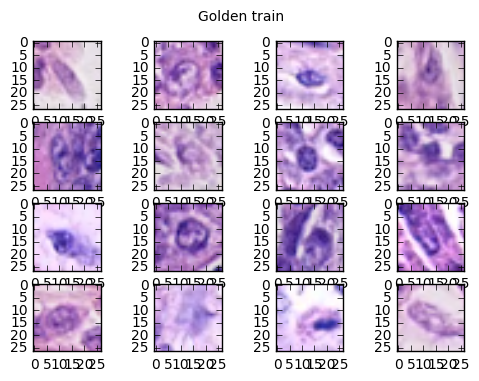

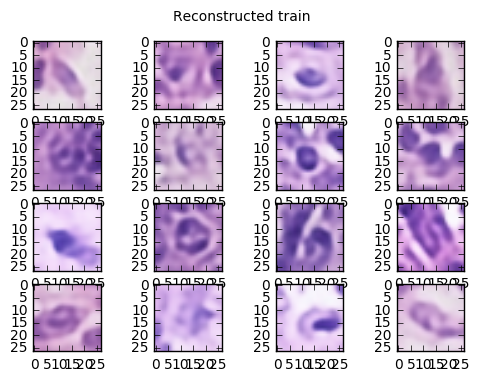

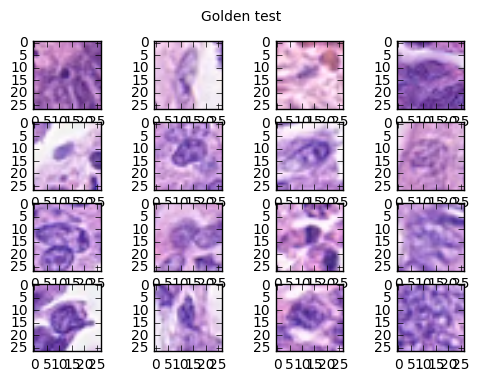

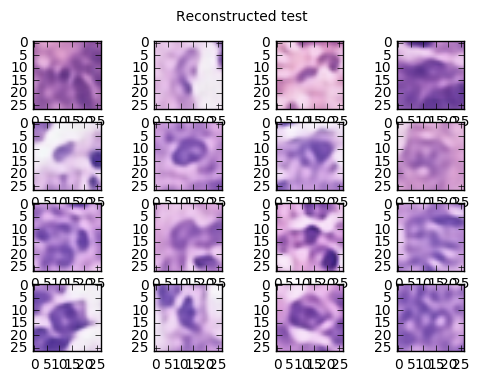

In [18]:
# Compare golden to best recreations
plt.figure()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(train_dict['patches'][i])
plt.suptitle("Golden train")

plt.figure()
imgs = sess.run(eval_reconstructed_tensor, feed_dict={
        patch_tensor:train_dict['patches'][:16],
    })
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(imgs[i])
plt.suptitle("Reconstructed train")

plt.figure()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(test_patches[i])
plt.suptitle("Golden test")

plt.figure()
imgs = sess.run(eval_reconstructed_tensor, feed_dict={
        patch_tensor:test_patches[:16],
    })
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(imgs[i])
plt.suptitle("Reconstructed test")

# Save Encodings

In [44]:
# Calculate the encodings for everything in the training and test sets
train_N = train_dict['patches'].shape[0]
test_N = test_patches.shape[0]
features_N = eval_encoded_tensor.get_shape().as_list()[1]
train_encodings = np.zeros((train_N, features_N))
test_encodings = np.zeros((test_N, features_N))
batch_size = 100 # We will do it in batches of 100 to save on memory

# First do the train set
for i in xrange(0, train_N, batch_size):
    train_encodings[i:i+batch_size] = sess.run(eval_encoded_tensor, feed_dict={
            patch_tensor:train_dict['patches'][i:i+batch_size]
        })
    
# Next do the test set
for i in xrange(0, test_N, batch_size):
    test_encodings[i:i+batch_size] = sess.run(eval_encoded_tensor, feed_dict={
            patch_tensor:test_patches[i:i+batch_size]
        })

In [45]:
# Okay now we want to write these out to disk
np.save("train_autoencodings.npy", train_encodings)
np.save("test_autoencodings.npy", test_encodings)

# Feature-Space Manipulations

In [19]:
categories

['epithelial', 'fibroblast', 'inflammatory', 'others']

epithelial : [ 3  5  6  7  8 11 12 13 15 16 17 18 19 20 21 23 25 26 29 34 38 41 48 52 53
 54 58 59 60 61 66 69 73 75 77 78 80 83 85 89]
fibroblast : [  9  14  28  31  32  35  36  39  44  47  50  62  65  67  68  72  74  76
  82  84  87  90  92  94  97 100 104 106 107 113 118 119 122 123 138 140
 141 145 146 151]
inflammatory : [  1  22  24  27  37  43  45  46  49  51  55  57  63  64  81  86  88  91
  96  98  99 102 105 108 112 115 117 124 130 132 133 134 135 137 142 150
 155 156 158 161]
others : [  0   2   4  10  30  33  40  42  56  70  71  79 114 128 129 165 166 173
 197 204 212 240 246 294 302 319 336 379 382 401 405 414 436 448 449 453
 456 457 483 486]


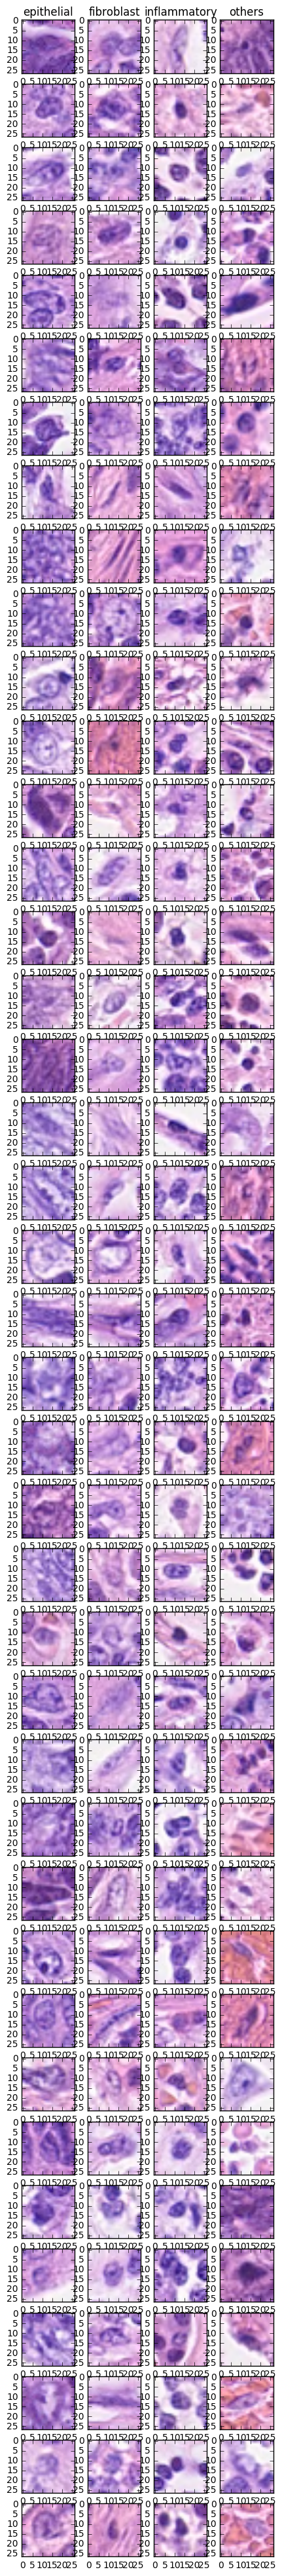

In [22]:
# Print some examples of the different categories of cells
plt.figure(figsize=(5,50))
num_examples_per_cat = 40
num_cat = len(categories)
for c in xrange(num_cat):
    examples = test_patches[np.equal(1, test_labels[:, c])]
    examples = examples[:num_examples_per_cat]
    indices = np.nonzero(test_labels[:, c])[0]
    indices = indices[:num_examples_per_cat]
    first = True
    for (i, e) in enumerate(examples):
        plt.subplot(num_examples_per_cat, num_cat, i*num_cat + c + 1)
        plt.imshow(e)
        if first:
            first = False
            plt.title(categories[c])
    print categories[c], ":", indices

In [23]:
import svm

In [24]:
ws = np.load("auto_svn_best_ws.npy")

In [25]:
def get_norm(ws, category):
    vec = ws[:-1,category]
    return np.divide(vec, np.linalg.norm(vec))

In [26]:
epithelial_normal = get_norm(ws, 0)
fibroblast_normal = get_norm(ws, 1)
inflammatory_normal = get_norm(ws, 2)
other_normal = get_norm(ws, 3)

Actual: fibroblast
Prediction: fibroblast
Prediction (epithelial): epithelial
Prediction (fibroblast): fibroblast
Prediction (inflammatory): inflammatory
Prediction (others): others


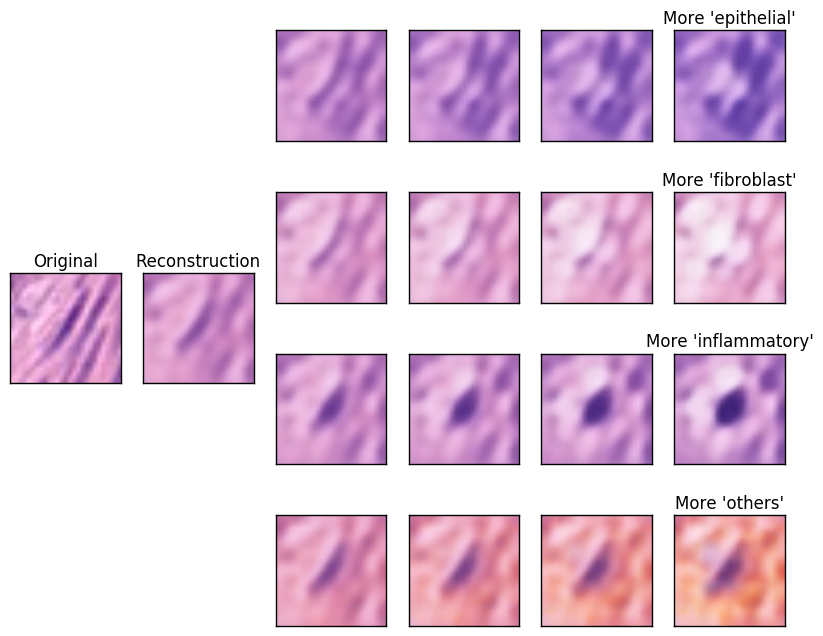

In [44]:
# IDS: 3399#555#269#62#825#736#2020#3700#12#964#99#1235
patch_id = 44

def ticks_off():
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])

patch = test_patches[patch_id]
encoding = sess.run(eval_encoded_tensor, feed_dict={
        patch_tensor: patch[np.newaxis, :, :, :],
    })
actual = np.argmax(test_labels[patch_id])
prediction = svm.get_multiclass_predictions(encoding, ws)[0][0]
reconstruction = sess.run(eval_reconstructed_tensor, feed_dict={
        eval_encoded_tensor: encoding
    })

print "Actual:", categories[actual]
print "Prediction:", categories[prediction]

c = len(categories)
amounts = [2, 3.3, 4.6, 6]
n = 2 + len(amounts)
plt.figure(figsize=(10,8))

plt.subplot(1, n, 1)
ticks_off()
plt.title("Original")
plt.imshow(patch)
plt.subplot(1, n, 2)
ticks_off()
plt.title("Reconstruction")
plt.imshow(reconstruction[0])
    
for (i, normal) in enumerate([epithelial_normal, fibroblast_normal, inflammatory_normal, other_normal]):
    label = categories[i]

    for (j, amount) in enumerate(amounts):
        noise = np.random.standard_normal(size=normal.shape)
        noise = np.divide(noise, np.linalg.norm(noise))
        tweaked_encoding = encoding + amount*normal #+ 3*noise
        tweaked_prediction = svm.get_multiclass_predictions(tweaked_encoding, ws)[0][0]
        tweaked_reconstruction = sess.run(eval_reconstructed_tensor, feed_dict={
                eval_encoded_tensor: tweaked_encoding
            })
        plt.subplot(c, n, 3+j+n*i)
        ticks_off()
        plt.imshow(tweaked_reconstruction[0])
        if 3 + j == n:
            plt.title("More '%s'" % label)
            print "Prediction (%s): %s" % (label, categories[tweaked_prediction])
plt.savefig("feature_space_viz/%d.png" % patch_id)

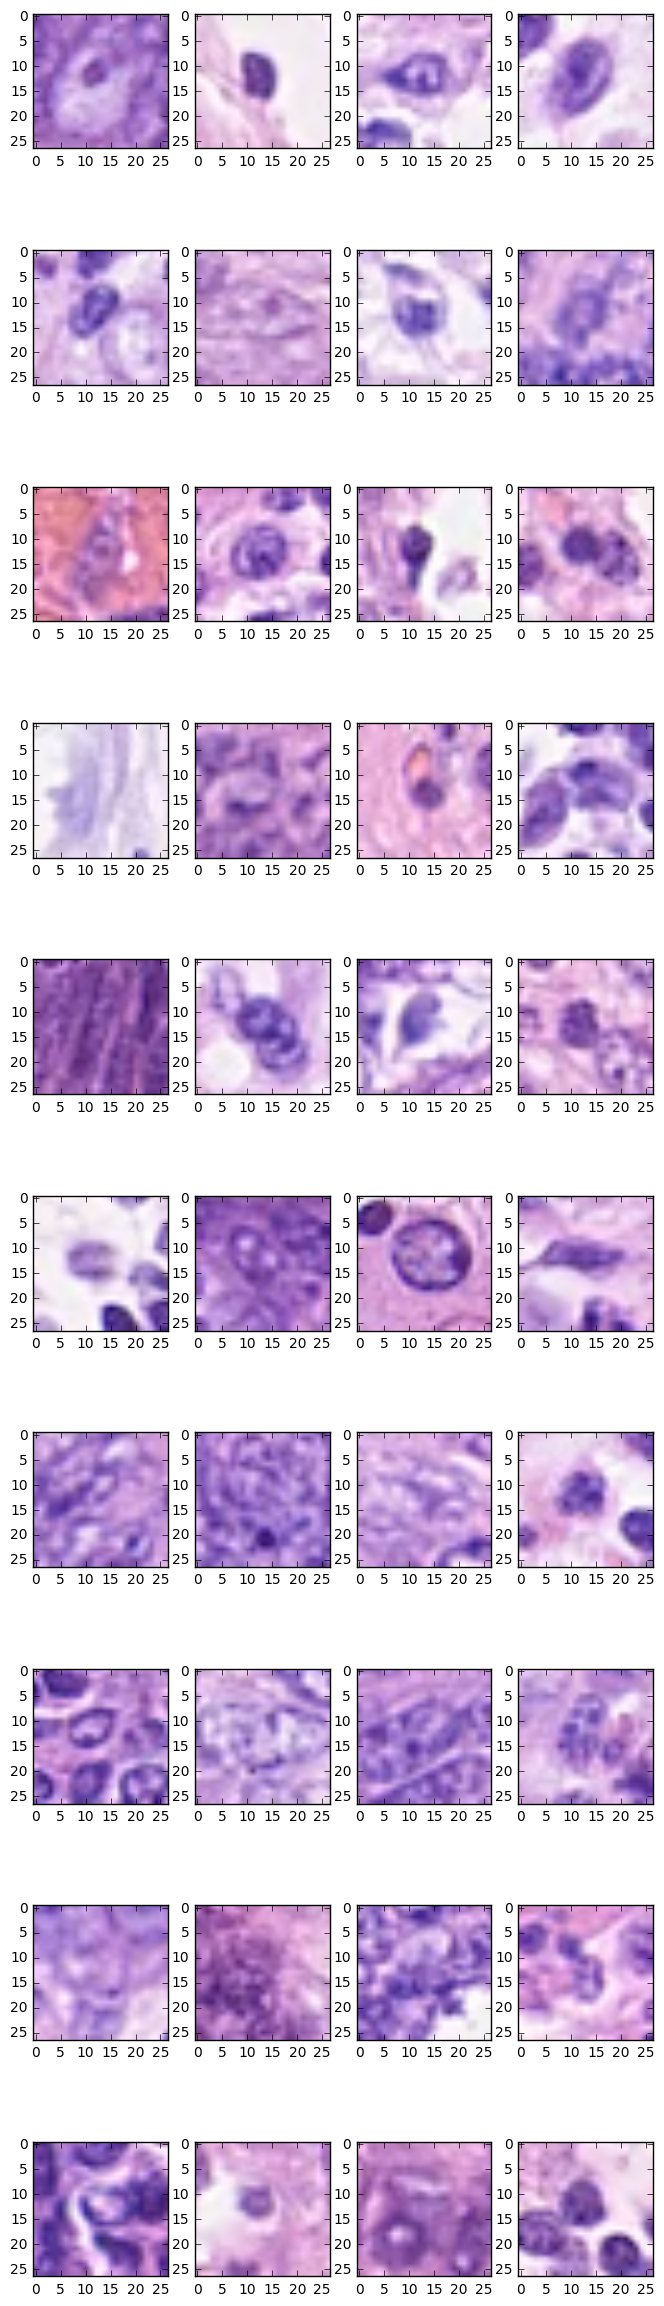

In [176]:
plt.figure(figsize=(8,30))
for i in range(10):
    for j in range(4):
        plt.subplot(10, 4, i*4+j+1)
        plt.imshow(test_patches[531+i*4+j])

In [181]:
my_ps = test_patches[531:531+100]

my_encode = sess.run(eval_encoded_tensor, feed_dict={
        patch_tensor: my_ps,
    })
prediction = svm.get_multiclass_predictions(my_encode, ws)[0]
actuals=np.argmax(test_labels[531:531+100], axis=1)

for i in range(10):
    for j in range(4):
        if prediction[i*4+j] != actuals[i*4+j]:
            print "!",
        print categories[prediction[i*4+j]],
    print ''

epithelial inflammatory inflammatory ! fibroblast 
inflammatory ! fibroblast ! inflammatory inflammatory 
others ! inflammatory ! fibroblast ! others 
fibroblast epithelial inflammatory inflammatory 
epithelial inflammatory inflammatory inflammatory 
! inflammatory epithelial epithelial ! inflammatory 
epithelial epithelial ! fibroblast inflammatory 
epithelial epithelial epithelial inflammatory 
epithelial epithelial epithelial fibroblast 
epithelial ! fibroblast epithelial inflammatory 
